## Exemplo Ilustrativo do Capítulo 4: Retropropagação a partir dos Princípios (Python/NumPy)

Este notebook implementa o nosso Perceptron de múltiplas camadas e o processo de aprendizagem usando apenas Python e a biblioteca NumPy. O objetivo aqui é ver a teoria e as equações dos Capítulos 1, 2 e 3 em sua forma mais pura e explícita.

Diferente do exemplo do próximo capítulo, aqui nós:
1.  **Não usaremos um framework de alto nível** como o TensorFlow para o treino. Todo o cálculo será feito "na mão".
2.  **Treinaremos com um vetor de cada vez**, em vez de lotes, para que possamos acompanhar a atualização dos pesos a cada exemplo.
3.  Implementaremos o cálculo do gradiente dos pesos (`∂E/∂W`) usando o **produto externo (`np.outer`)**, espelhando perfeitamente a derivação matemática para um único exemplo de treino.

Este é o alicerce. Ao entender este código, você entenderá o que os frameworks modernos fazem por baixo dos panos.

### Passo 1: Preparando o Ambiente e os Dados

Primeiro, preparamos nosso ambiente e dados. Usaremos `NumPy` para todos os nossos cálculos matemáticos e `Matplotlib` para visualização.

Por conveniência, usaremos a biblioteca `tensorflow` *apenas uma vez* para baixar o dataset MNIST de forma simples. A partir do carregamento, todos os dados serão arrays NumPy e o TensorFlow não será mais utilizado.

O pré-processamento é idêntico ao do exemplo seguinte: normalizamos os pixels, "achatamos" as imagens em vetores e usamos _one-hot encoding_ para as respostas desejadas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # Usado APENAS para carregar o dataset convenientemente

# Carregar o dataset MNIST
(x_train, z_train), (x_test, z_test) = tf.keras.datasets.mnist.load_data()

# Função para one-hot encoding usando apenas NumPy
def to_one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

# Pré-processamento com NumPy
x_train = (x_train.astype("float32") / 255.0).reshape(60000, 784)
x_test = (x_test.astype("float32") / 255.0).reshape(10000, 784)

z_train_one_hot = to_one_hot(z_train).astype('float32')
z_test_one_hot = to_one_hot(z_test).astype('float32')

print("Dados prontos e em formato NumPy!")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dados prontos e em formato NumPy!


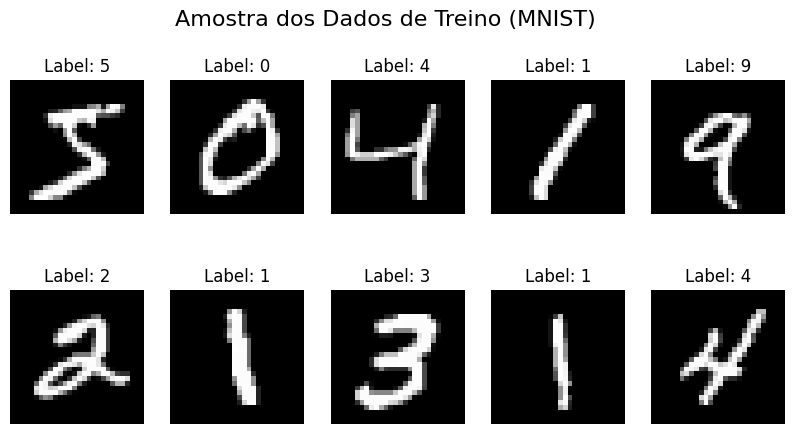

In [ ]:
# O código de visualização é o mesmo, pois Matplotlib funciona com NumPy
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {z_train[i]}") # Usamos o z_train original para o título
    plt.axis('off')
plt.suptitle("Amostra dos Dados de Treino (MNIST)", fontsize=16)
plt.show()

### Passo 2: Definindo as Ferramentas (Funções)

Como não estamos usando uma classe de modelo como no Keras, precisamos definir todas as nossas "ferramentas" como funções separadas. Aqui, criaremos as funções de ativação (ReLU e Sigmoid) e suas respectivas derivadas, a função de custo (Erro Quadrado Médio) e sua derivada, e uma função para inicializar os pesos e biases da nossa rede.

In [ ]:
# Funções de Ativação e suas derivadas
def relu(y):
    return np.maximum(0, y)

def relu_derivative(y):
    return np.where(y > 0, 1, 0)

def sigmoid(y):
    return 1 / (1 + np.exp(-y))

def sigmoid_derivative(a):
    return a * (1 - a)

# Função de Custo e sua derivada
def mean_squared_error(z, P):
    return np.mean((z - P)**2)

def mean_squared_error_derivative(z, P):
    return P - z

# Função para inicializar os parâmetros da rede
def inicializar_parametros(layer_dims):
    W = {}
    b = {}
    for l in range(1, len(layer_dims)):
        # Inicializamos com valores aleatórios pequenos para quebrar a simetria
        W[l] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        b[l] = np.zeros((layer_dims[l], 1))
    return W, b

### Passo 3: O Treino com Retropropagação "Na Mão"

Esta é a célula central do nosso exemplo. Aqui, implementamos o processo de aprendizagem do zero. O loop externo itera através das "épocas" (passagens completas pelo dataset), e o loop interno itera sobre **cada exemplo de treino individualmente**.

Para cada imagem `x` e seu rótulo `z`:
1.  **Forward Pass:** Calculamos a saída da rede `P` passando `x` por todas as camadas, guardando os valores intermediários `y` e `a`.
2.  **Cálculo do Erro:** Medimos o erro `E` da previsão.
3.  **Backpropagation:** Começando da última camada, calculamos os gradientes `∂E/∂W` e `∂E/∂b` para cada camada, usando `np.outer` para os pesos, exatamente como na teoria.
4.  **Atualização:** Subtraímos uma fração do gradiente (controlada pela taxa de aprendizagem) dos parâmetros atuais, ajustando a rede na direção que minimiza o erro.

In [ ]:
# --- Hiperparâmetros e Arquitetura ---
taxa_aprendizagem = 0.01
epocas = 5
# A arquitetura é a mesma: entrada 784 -> camada oculta 128 -> camada oculta 64 -> saída 10
layer_dims = [784, 128, 64, 10]

# --- Inicialização ---
W, b = inicializar_parametros(layer_dims)
num_camadas = len(layer_dims) - 1
historico_custo = []

print("Iniciando o treino em Python/NumPy...")
for i in range(epocas):
    custo_total_epoca = 0
    # O loop interno itera sobre cada exemplo
    for x, z in zip(x_train, z_train_one_hot):
        # Remodelar x e z para serem vetores coluna
        x = x.reshape(-1, 1)
        z = z.reshape(-1, 1)

        # --- 1. Forward Pass ---
        ativacoes = {'a0': x}
        linearidades = {}

        a_anterior = x
        for l in range(1, num_camadas + 1):
            y = np.dot(W[l], a_anterior) + b[l]
            linearidades[f'y{l}'] = y

            if l == num_camadas: # Última camada
                a = sigmoid(y)
            else: # Camadas ocultas
                a = relu(y)
            ativacoes[f'a{l}'] = a
            a_anterior = a

        P = ativacoes[f'a{num_camadas}']
        custo_total_epoca += mean_squared_error(z, P)

        # --- 2. Backpropagation ---
        # Gradientes para os pesos e biases
        dE_dW = {}
        dE_db = {}

        # Semente do Gradiente (para a última camada L)
        dE_dP = mean_squared_error_derivative(z, P)
        dP_dyL = sigmoid_derivative(P)
        dE_dy = dE_dP * dP_dyL # Delta inicial

        # Loop Reverso
        for l in reversed(range(1, num_camadas + 1)):
            a_anterior = ativacoes[f'a{l-1}']

            # Gradientes da camada 'l'
            # USANDO O PRODUTO EXTERNO, COMO NA TEORIA!
            dE_dW[l] = np.outer(dE_dy, a_anterior)
            dE_db[l] = dE_dy

            # Propagar o erro para a camada anterior (se não for a primeira)
            if l > 1:
                y_anterior = linearidades[f'y{l-1}']
                dE_da_anterior = np.dot(W[l].T, dE_dy)
                da_anterior_dy_anterior = relu_derivative(y_anterior)
                dE_dy = dE_da_anterior * da_anterior_dy_anterior

        # --- 3. Atualização dos Parâmetros ---
        for l in range(1, num_camadas + 1):
            W[l] -= taxa_aprendizagem * dE_dW[l]
            b[l] -= taxa_aprendizagem * dE_db[l]

    # Fim da época
    custo_medio = custo_total_epoca / len(x_train)
    historico_custo.append(custo_medio)
    print(f"Época {i + 1}/{epocas} - Custo Médio: {custo_medio:.6f}")

print("Treino finalizado!")

Iniciando o treino em Python/NumPy...
Época 1/5 - Custo Médio: 0.065687
Época 2/5 - Custo Médio: 0.014409
Época 3/5 - Custo Médio: 0.008436
Época 4/5 - Custo Médio: 0.006206
Época 5/5 - Custo Médio: 0.004944
Treino finalizado!


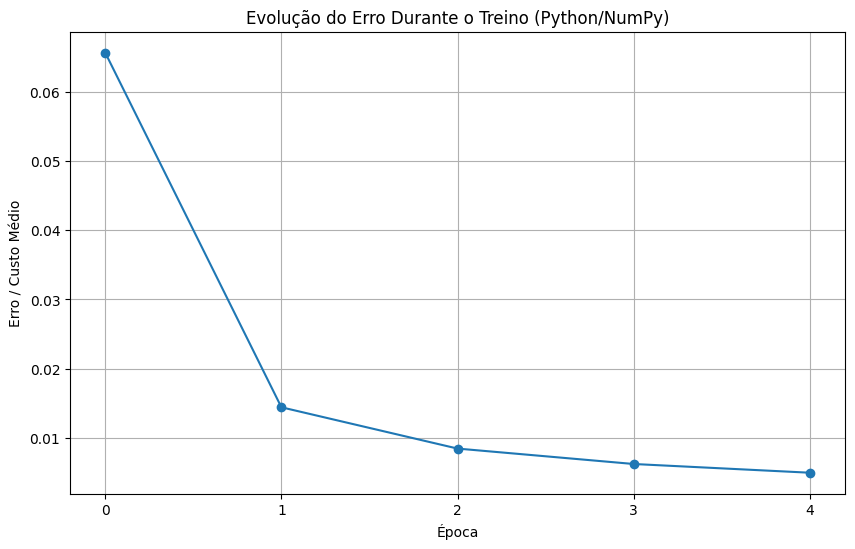

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(historico_custo, marker='o')
plt.xlabel("Época")
plt.ylabel("Erro / Custo Médio")
plt.title("Evolução do Erro Durante o Treino (Python/NumPy)")
plt.grid(True)
plt.xticks(range(epocas))
plt.show()

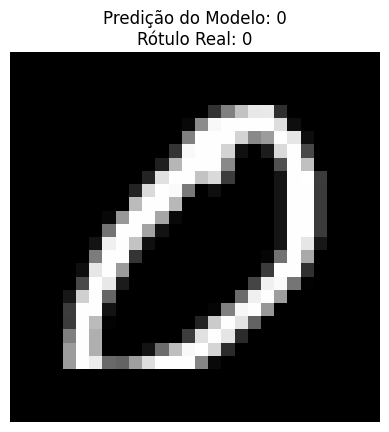

In [ ]:
def forward_pass_teste(x, W, b):
    a = x.reshape(-1, 1)
    num_camadas = len(W)
    for l in range(1, num_camadas + 1):
        y = np.dot(W[l], a) + b[l]
        if l == num_camadas:
            a = sigmoid(y)
        else:
            a = relu(y)
    return a

def testar_modelo_numpy():
    idx_aleatorio = np.random.randint(0, len(x_test))

    img = x_test[idx_aleatorio]
    label_real = z_test[idx_aleatorio] # Usamos o z_test original

    vetor_predicao = forward_pass_teste(img, W, b)
    label_predito = np.argmax(vetor_predicao)

    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Predição do Modelo: {label_predito}\nRótulo Real: {label_real}")
    plt.axis('off')
    plt.show()

# Execute esta célula várias vezes para testar!
testar_modelo_numpy()